In [77]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book
HopsworksSettings initialized!


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🗒️ This notebook is divided into the following sections:

1. Select features for the model and create a Feature View with the selected features
2. Create training data using the feature view
3. Train model
4. Evaluate model performance
5. Save model to model registry

### <span style='color:#ff5f27'> 📝 Imports

In [78]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [ ]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
locations_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
locations = json.loads(locations_str)
country=locations[0]['country']
city=locations[0]['city']
#street=location['street']

2025-11-18 11:36:44,052 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-18 11:36:44,069 INFO: Initializing external client
2025-11-18 11:36:44,070 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-18 11:36:45,298 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286301


In [93]:
# Retrieve feature groups
# air_quality_fg = fs.get_feature_group(
#     name='air_quality',
#     version=3,
# )

aq_fg_munich = fs.get_feature_group(
    name='air_quality_munich',
    version=1,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)

--- 

## <span style="color:#ff5f27;"> 🖍 Feature View Creation and Retrieving </span>

## C and A grade task

In [94]:
# Select features for training data.
#selected_features = air_quality_fg.select(['pm25', 'date', 'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d']).join(weather_fg.select_features(), on=['city'])
selected_features = aq_fg_munich.select(['station_id', 'pm25', 'date', 'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d']).join(weather_fg.select_features(), on=['city'])

2025-11-18 14:05:29,436 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


### Feature Views

`Feature Views` are selections of features from different **Feature Groups** that make up the input and output API (or schema) for a model. A **Feature Views** can create **Training Data** and also be used in Inference to retrieve inference data.

The Feature Views allows a schema in form of a query with filters, defining a model target feature/label and additional transformation functions (declarative feature encoding).

In order to create Feature View we can use `FeatureStore.get_or_create_feature_view()` method.

You can specify the following parameters:

- `name` - name of a feature group.

- `version` - version of a feature group.

- `labels`- our target variable.

- `transformation_functions` - declarative feature encoding (not used here)

- `query` - selected features/labels for the model 

In [58]:
feature_view = fs.get_or_create_feature_view(
    name='air_quality_fv',
    description="weather features with air quality as the target",
    version=2,
    labels=['pm25'],
    query=selected_features,
)

In [95]:
feature_view = fs.get_or_create_feature_view(
    name ='air_quality_munich_fv',
    description="weather features with air quality as the target for Munich",
    version=1,
    labels=['pm25'],
    query=selected_features,
)

## <span style="color:#ff5f27;">🪝 Split the training data into train/test data sets </span>

We use a time-series split here, with training data before this date `start_date_test_data` and test data after this date

In [96]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [97]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start, shuffle=False
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.88s) 


In [123]:
print(f"Training data: {X_train.shape}, Test data: {X_test.shape}")

Training data: (3691, 9), Test data: (1007, 9)


In [125]:
print(y_train.head(10))
print(y_train.columns)
print(X_train.columns)

   pm25
0  21.0
1  22.0
2  29.0
3  28.0
4  27.0
5   7.0
6  21.0
7  21.0
8  13.0
9   9.0
Index(['pm25'], dtype='object')
Index(['station_id', 'date', 'pm25_lag_1d', 'pm25_lag_2d', 'pm25_lag_3d',
       'temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max',
       'wind_direction_10m_dominant'],
      dtype='object')


In [126]:
print("Unique values in y_train:", y_train.iloc[:,0].unique()[:20])

Unique values in y_train: [21. 22. 29. 28. 27.  7. 13.  9. 11. 16. 14. 12. 10. 17. 23. 26. 36. 40.
 38. 39.]


In [122]:
X_train.head(25)

,station_id,date,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,6043,2023-03-24 00:00:00+00:00,NaN,NaN,NaN,10.752749,7.8,23.452555,234.309830
1,6041,2023-03-24 00:00:00+00:00,NaN,NaN,NaN,10.752749,7.8,23.452555,234.309830
2,6037,2023-03-24 00:00:00+00:00,NaN,NaN,NaN,10.752749,7.8,23.452555,234.309830
3,6044,2023-03-24 00:00:00+00:00,NaN,NaN,NaN,10.752749,7.8,23.452555,234.309830
4,6042,2023-03-24 00:00:00+00:00,NaN,NaN,NaN,10.752749,7.8,23.452555,234.309830
5,6041,2023-03-25 00:00:00+00:00,22.0,NaN,NaN,8.275666,1.0,34.623692,251.671036
6,6037,2023-03-25 00:00:00+00:00,29.0,NaN,NaN,8.275666,1.0,34.623692,251.671036
7,6044,2023-03-25 00:00:00+00:00,28.0,NaN,NaN,8.275666,1.0,34.623692,251.671036
8,6042,2023-03-25 00:00:00+00:00,27.0,NaN,NaN,8.275666,1.0,34.623692,251.671036
9,6043,2023-03-25 00:00:00+00:00,21.0,NaN,NaN,8.275666,1.0,34.623692,251.671036


In [115]:
X_features = X_train.drop(columns=['date'])
X_test_features = X_test.drop(columns=['date'])

In [119]:
X_features.head()

,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,6043,NaN,NaN,NaN,10.752749,7.8,23.452555,234.30983
1,6041,NaN,NaN,NaN,10.752749,7.8,23.452555,234.30983
2,6037,NaN,NaN,NaN,10.752749,7.8,23.452555,234.30983
3,6044,NaN,NaN,NaN,10.752749,7.8,23.452555,234.30983
4,6042,NaN,NaN,NaN,10.752749,7.8,23.452555,234.30983


In [109]:
print("NaNs in y_train:", y_train.isna().sum().values[0])
print("NaNs in y_test:",  y_test.isna().sum().values[0])

NaNs in y_train: 0
NaNs in y_test: 0


In [108]:
mask_test = ~y_test.iloc[:, 0].isna()
X_test = X_test[mask_test]
y_test = y_test[mask_test]

In [110]:
y_train

,pm25
0,21.0
1,22.0
2,29.0
3,28.0
4,27.0
...,...
3686,51.0
3687,52.0
3688,40.0
3689,43.0


The `Feature View` is now saved in Hopsworks and you can retrieve it using `FeatureStore.get_feature_view(name='...', version=1)`.

---

## <span style="color:#ff5f27;">🧬 Modeling</span>

We will train a regression model to predict pm25 using our 7 features (wind_speed, wind_dir, temp, precipitation + lagged pm25_i, i = 1,2,3)

In [111]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [117]:
X_test_features

,station_id,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
3691,6043,40.0,40.0,56.0,17.500669,0.000000,11.304229,89.614838
3692,6041,43.0,49.0,47.0,17.500669,0.000000,11.304229,89.614838
3693,6037,54.0,53.0,59.0,17.500669,0.000000,11.304229,89.614838
3694,6044,51.0,52.0,56.0,17.500669,0.000000,11.304229,89.614838
3695,6042,52.0,47.0,48.0,17.500669,0.000000,11.304229,89.614838
...,...,...,...,...,...,...,...,...
4693,6042,41.0,55.0,NaN,5.275666,7.799999,20.448032,276.300629
4695,6043,23.0,36.0,55.0,2.650000,0.000000,1.080000,90.000000
4696,6041,33.0,38.0,61.0,2.650000,0.000000,1.080000,90.000000
4697,6044,33.0,45.0,66.0,2.650000,0.000000,1.080000,90.000000


In [113]:
y_test

,pm25
3691,34.0
3692,46.0
3693,51.0
3694,45.0
3695,48.0
...,...
4693,41.0
4695,25.0
4696,17.0
4697,21.0


In [118]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 689.4447072459155
R squared: 0.08423759803121045


In [127]:
df = y_test
df['predicted_pm25'] = y_pred

In [136]:
X_test.head(10)

,station_id,date,pm25_lag_1d,pm25_lag_2d,pm25_lag_3d,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
3691,6043,2025-05-01 00:00:00+00:00,40.0,40.0,56.0,17.500669,0.0,11.304229,89.614838
3692,6041,2025-05-01 00:00:00+00:00,43.0,49.0,47.0,17.500669,0.0,11.304229,89.614838
3693,6037,2025-05-01 00:00:00+00:00,54.0,53.0,59.0,17.500669,0.0,11.304229,89.614838
3694,6044,2025-05-01 00:00:00+00:00,51.0,52.0,56.0,17.500669,0.0,11.304229,89.614838
3695,6042,2025-05-01 00:00:00+00:00,52.0,47.0,48.0,17.500669,0.0,11.304229,89.614838
3696,6043,2025-05-02 00:00:00+00:00,34.0,40.0,40.0,20.136084,0.0,10.385547,239.191818
3697,6041,2025-05-02 00:00:00+00:00,46.0,43.0,49.0,20.136084,0.0,10.385547,239.191818
3698,6037,2025-05-02 00:00:00+00:00,51.0,54.0,53.0,20.136084,0.0,10.385547,239.191818
3699,6044,2025-05-02 00:00:00+00:00,45.0,51.0,52.0,20.136084,0.0,10.385547,239.191818
3700,6042,2025-05-02 00:00:00+00:00,48.0,52.0,47.0,20.136084,0.0,10.385547,239.191818


In [138]:
df['date'] = X_test['date']
df['station_id'] = X_test['station_id']
df = df.sort_values(by=['date', 'station_id'])
df.head(10)

,pm25,predicted_pm25,date,station_id
3693,51.0,56.564529,2025-05-01 00:00:00+00:00,6037
3692,46.0,49.562050,2025-05-01 00:00:00+00:00,6041
3695,48.0,56.353001,2025-05-01 00:00:00+00:00,6042
3691,34.0,48.511467,2025-05-01 00:00:00+00:00,6043
3694,45.0,50.702011,2025-05-01 00:00:00+00:00,6044
3698,58.0,54.675926,2025-05-02 00:00:00+00:00,6037
3697,43.0,45.312374,2025-05-02 00:00:00+00:00,6041
3700,52.0,49.350159,2025-05-02 00:00:00+00:00,6042
3696,34.0,35.522053,2025-05-02 00:00:00+00:00,6043
3699,53.0,46.139034,2025-05-02 00:00:00+00:00,6044


In [129]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

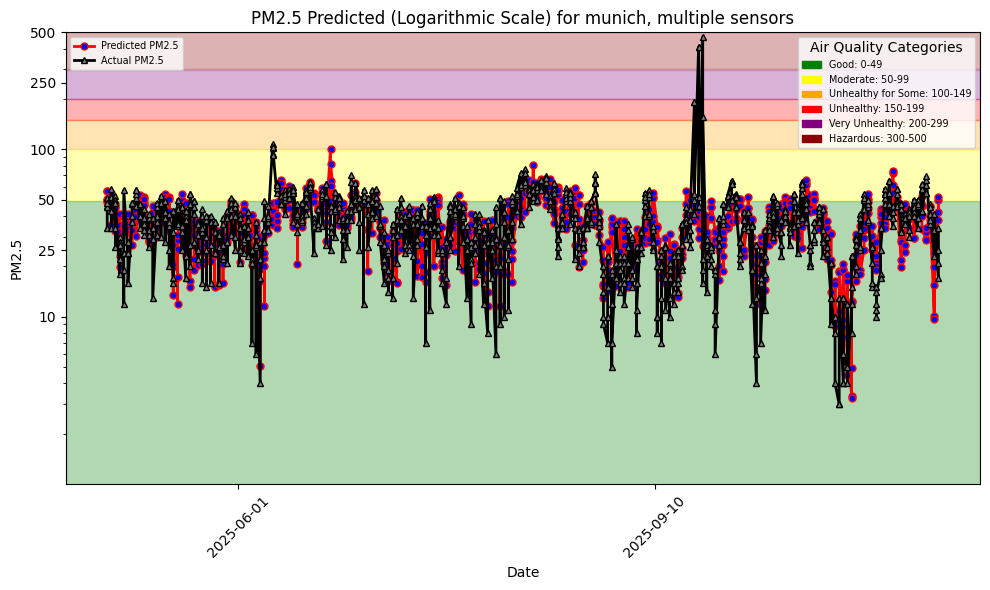

In [135]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, "multiple sensors", df, file_path, hindcast=True) 
plt.show()

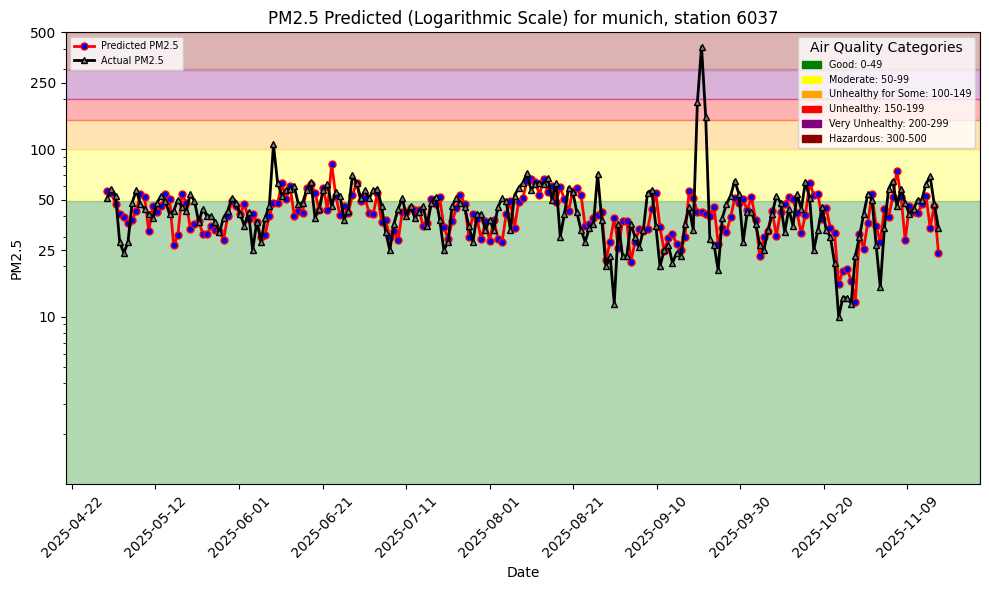

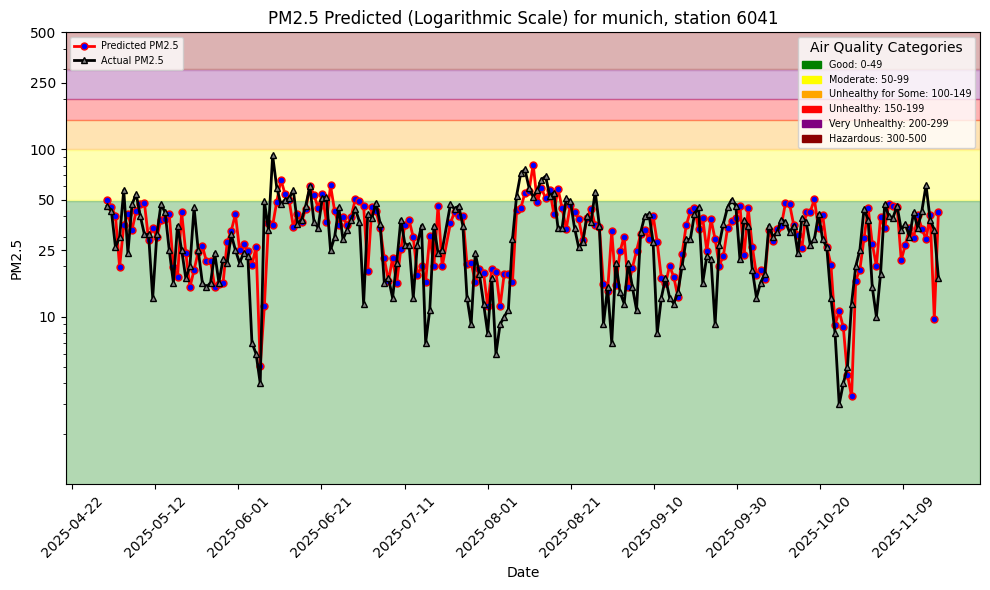

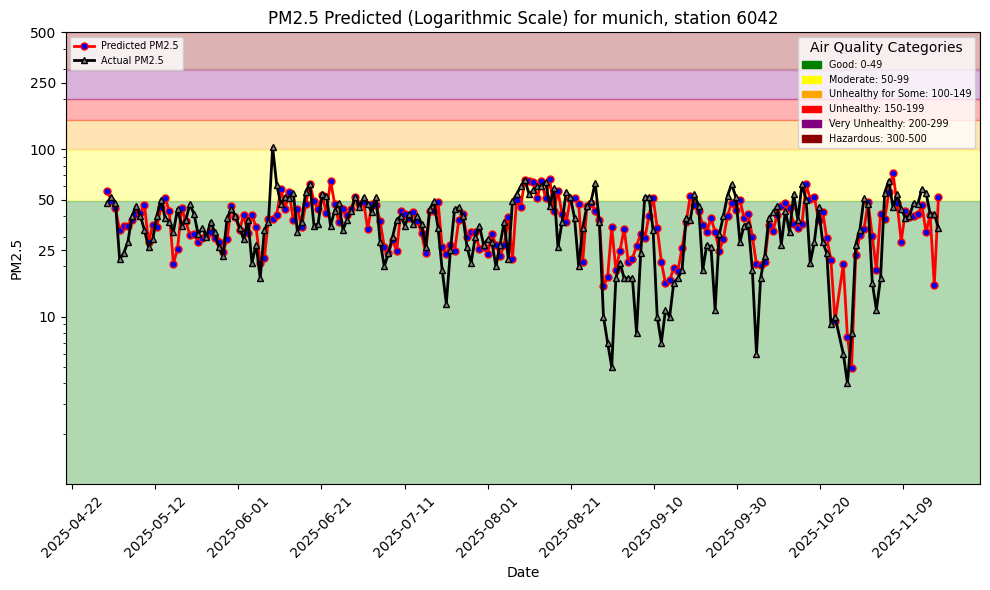

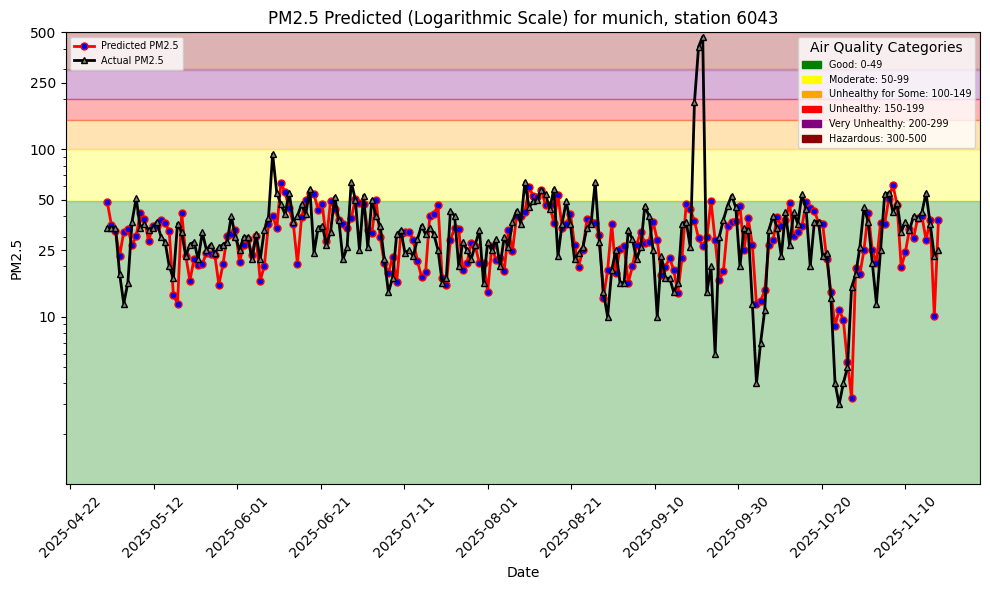

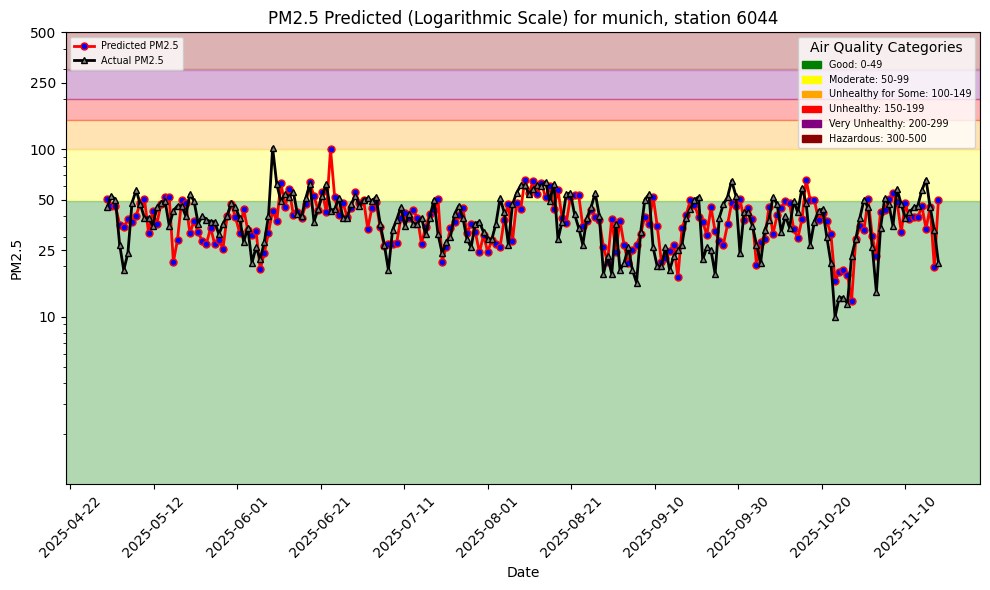

In [139]:
for sid in df["station_id"].unique():
    df_sid = df[df.station_id == sid]
    file_path = f"{images_dir}/pm25_hindcast_{sid}.png"

    util.plot_air_quality_forecast(
        city,
        f"station {sid}",
        df_sid,
        file_path,
        hindcast=True
    )
    plt.show()

In [ ]:
# Here we see some spikes in pm25 above 100. The spike in september is probablty due to octoberfest that is held there. 
print(df[df['pm25'] > 100])

       pm25  predicted_pm25                       date
3891  107.0       48.060310  2025-06-10 00:00:00+00:00
3894  102.0       43.086857  2025-06-10 00:00:00+00:00
3895  103.0       38.150852  2025-06-10 00:00:00+00:00
4400  191.0       37.326023  2025-09-20 00:00:00+00:00
4402  191.0       42.308739  2025-09-20 00:00:00+00:00
4405  410.0       42.292755  2025-09-21 00:00:00+00:00
4406  410.0       29.410616  2025-09-21 00:00:00+00:00
4410  472.0       26.404741  2025-09-22 00:00:00+00:00
4412  156.0       41.279766  2025-09-22 00:00:00+00:00


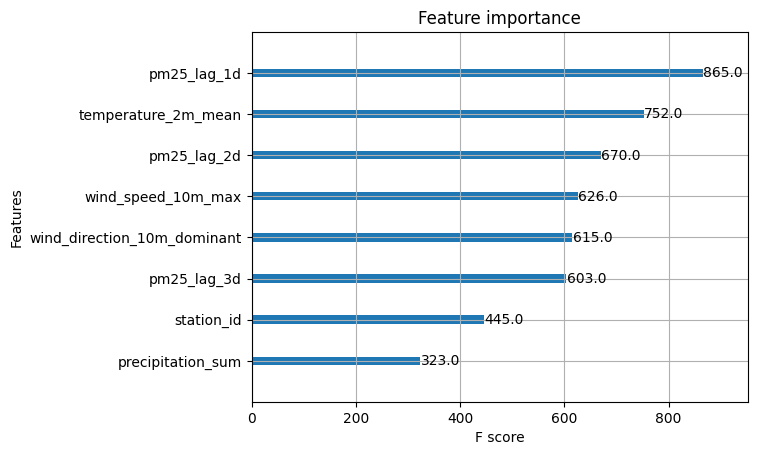

In [131]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [140]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [141]:
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [142]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/air_quali…

Uploading /Users/fredrikstrom/Documents/KTH_Dokument/Scalable ML/labs/mlfs-book/notebooks/airquality/model_sch…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1286301/models/air_quality_xgboost_model/3


Model(name: 'air_quality_xgboost_model', version: 3)

---
## <span style="color:#ff5f27;">⏭️ **Next:** Part 04: Batch Inference</span>

In the following notebook you will use your model for Batch Inference.
